## 3.7 softmax回归的简洁实现

In [1]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import os

sys.path.append("..")
import d2lzh_pytorch as d2l

### 读数据

In [2]:
batch_size = 256

directory = os.path.abspath(os.path.join(os.getcwd(), "../", "Datasets"))
if not os.path.exists(directory):
    os.makedirs(directory)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=None, root=directory)

D:\Anaconda3\envs\TorchCPU\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 建模，其中先把x拍平再传入模型

In [3]:
num_inputs = 784
num_outputs = 10


class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):  # x shape: (batch, 1, 28, 28)
        y = self.linear(x.view(x.shape[0], -1))
        return y


# 正常声明是这样的，但是x还有一些问题
# net = LinearNet(num_inputs, num_outputs)

# 我们将对x的形状转换的这个功能自定义一个FlattenLayer
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()

    def forward(self, x):  # x shape: (batch, *, *, ...)
        return x.view(x.shape[0], -1)


from collections import OrderedDict

# 这样我们就可以更方便地定义我们的模型：
net = nn.Sequential(
    # FlattenLayer(),
    # nn.Linear(num_inputs, num_outputs)
    OrderedDict([
        ('flatten', FlattenLayer()),
        ('linear', nn.Linear(num_inputs, num_outputs))
    ])
)

### 训练

In [4]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

loss = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 5
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.750, test acc 0.788
epoch 2, loss 0.0022, train acc 0.814, test acc 0.795
epoch 3, loss 0.0021, train acc 0.825, test acc 0.819
epoch 4, loss 0.0020, train acc 0.832, test acc 0.822
epoch 5, loss 0.0019, train acc 0.836, test acc 0.822


### 可视化预测

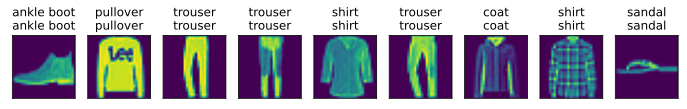

In [5]:
# 可视化预测
X, y = iter(test_iter).next()

true_labels = d2l.get_fashion_mnist_labels(y.numpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

d2l.show_fashion_mnist(X[0:9], titles[0:9])